### Imports and Preprocessing

In [13]:
import rasterio
import os
import shutil
import numpy as np
from rasterio.plot import show
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
import tensorflow as tf
from PIL import Image
import os
import cv2
from skimage import exposure
from keras.models import load_model
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [16]:
img = rasterio.open('k3_20191229071905_40634_06371169_l1g_nrg_chip.tif')

In [17]:
full_img = img.read()

In [18]:
new_img1_b1 = ((full_img[0] - full_img[0].min()) * (1/(full_img[0].max() - full_img[0].min()) * 255))
new_img1_b2 = ((full_img[1] - full_img[1].min()) * (1/(full_img[1].max() - full_img[1].min()) * 255))
new_img1_b3 = ((full_img[2] - full_img[2].min()) * (1/(full_img[2].max() - full_img[2].min()) * 255))
new_img1_3L = np.stack([new_img1_b1/3,new_img1_b2/3,new_img1_b2/3],axis = 2)
new_img = np.mean(new_img1_3L, axis=2)

In [19]:
cv2.imwrite('LR_IMG_bW_2.tif', new_img.reshape(new_img.shape[0], new_img.shape[1],1))

True

In [20]:
# size of patches
patch_size = 128

# Number of classes 
n_classes = 6

In [21]:
SIZE_X = (new_img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (new_img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(new_img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)   

In [8]:
#large_img = large_img.reshape(4608, 4992,1)

In [22]:
model = load_model('gen_e_15.h5', compile=False)

### Super Resolution Process

2023-01-17 23:45:05.267505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 0s 156ms/step


/var/folders/9_/28pnd_xj5j145x2rznbmddp80000gn/T/ipykernel_2021/3376904276.py:29: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.

  matched = exposure.match_histograms(pred, ref, multichannel=multi)


1/1 [==============================] - 0s 158ms/step

1/1 [==============================] - 0s 153ms/step

1/1 [==============================] - 0s 170ms/step

1/1 [==============================] - 0s 156ms/step

1/1 [==============================] - 0s 150ms/step

1/1 [==============================] - 0s 150ms/step

1/1 [==============================] - 0s 152ms/step

1/1 [==============================] - 0s 150ms/step

1/1 [==============================] - 0s 156ms/step

1/1 [==============================] - 0s 150ms/step

1/1 [==============================] - 0s 154ms/step

1/1 [==============================] - 0s 165ms/step

1/1 [==============================] - 0s 176ms/step

1/1 [==============================] - 0s 159ms/step

1/1 [==============================] - 0s 163ms/step

1/1 [==============================] - 0s 171ms/step

1/1 [==============================] - 0s 161ms/step

1/1 [==============================] - 0s 154ms/step

1/1 [=======================

True

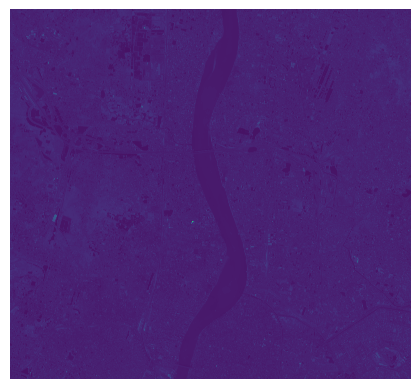

In [23]:

patches_img = patchify(large_img, (patch_size, patch_size), step=patch_size)  #Step=256 for 256 patches means no overlap
#patches_img = patches_img[:,:,0,:,:,:]

def log_transformed(img):
    c = 255/(np.log(1 + np.max(img)))
    log_transformed = c * np.log(1 + img)

    # Specify the data type.
    log_transformed = np.array(log_transformed, dtype = np.uint8)
    return log_transformed


patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        #single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        #single_patch_img = np.expand_dims(single_patch_img, axis=0)
        single_patch_img = log_transformed(single_patch_img)
        single_patch_img = single_patch_img.reshape(1,patch_size, patch_size)
        pred = model.predict(single_patch_img)
        # pred = np.argmax(pred, axis=3)
        # pred = pred[0, :,:]
        ref = patches_img[i,j,:,:].reshape(1,128,128,1)
        multi = True if pred.shape[-1] > 1 else False
        matched = exposure.match_histograms(pred, ref, multichannel=multi)
        
        patched_prediction.append(matched)
        # plt.figure(figsize=(10, 5))
        # plt.subplot(131)
        # plt.title('Source')
        # plt.imshow(pred[0,:,:,:],cmap='gray')
        # plt.subplot(132)
        # plt.title('Reference')
        # plt.imshow(ref[0,:,:,:],cmap='gray')
        # plt.subplot(133)
        # plt.title('Matched')
        # plt.imshow(matched[0,:,:,:],cmap='gray')
        # plt.show()


# ref = patched_prediction[0]

# for i in range(len(patched_prediction) - 1): 

#     src = patched_prediction[i + 1]
#     multi = True if src.shape[-1] > 1 else False
#     matched = exposure.match_histograms(src, ref, multichannel=multi)
#     patched_prediction[i + 1] = matched
    
    
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2]*2, patches_img.shape[3]*2])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0]*2, large_img.shape[1]*2))

plt.imshow(unpatched_prediction)
plt.axis('off')

cv2.imwrite('SR_IMG_Full_2.tif', unpatched_prediction.reshape(large_img.shape[0]*2, large_img.shape[1]*2,1))

### Histogram Matching

In [47]:
src = patched_prediction[0]
ref = patched_prediction[100]

In [48]:
multi = True if src.shape[-1] > 1 else False
matched = exposure.match_histograms(src, ref, multichannel=multi)

/var/folders/9_/28pnd_xj5j145x2rznbmddp80000gn/T/ipykernel_4752/2226372664.py:2: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.

  matched = exposure.match_histograms(src, ref, multichannel=multi)


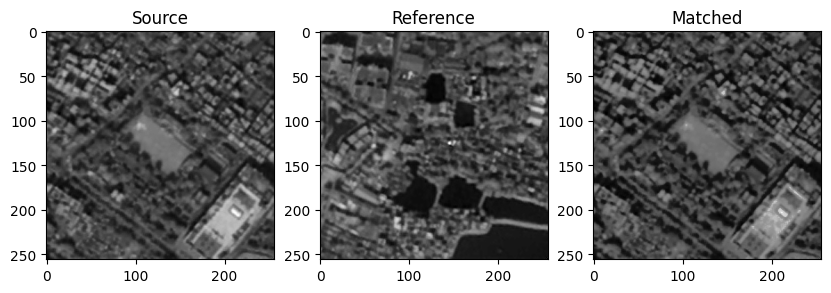

In [49]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.title('Source')
plt.imshow(src[0,:,:,:],cmap='gray')
plt.subplot(132)
plt.title('Reference')
plt.imshow(ref[0,:,:,:],cmap='gray')
plt.subplot(133)
plt.title('Matched')
plt.imshow(matched[0,:,:,:],cmap='gray')
plt.show()

### Before Histogram Matching

(-0.5, 9983.5, 9215.5, -0.5)

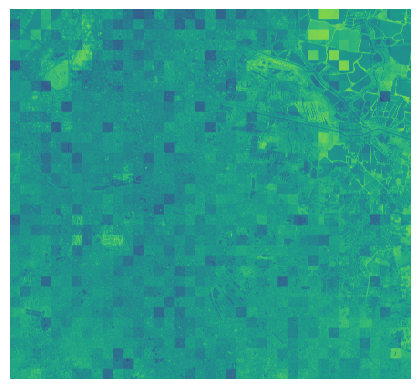

In [29]:
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2]*2, patches_img.shape[3]*2])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0]*2, large_img.shape[1]*2))

plt.imshow(unpatched_prediction)
plt.axis('off')